# Pythonで基礎から機械学習 重回帰分析

今回は、前回の単回帰分析を読んだことを前提の内容となっております。ご了承ください。

重回帰分析は、単回帰分析の入力変数が1つだったのが、複数（n）になったものです。それにより、単回帰から、以下のような変化があります。

- 行列を使った計算が増える（複雑になる）
- 複数の入力変数の粒度を揃えるために正規化が必要
- 単回帰と同様の計算に対して、入力変数の数に応じた補正が必要になる場合がある
- 入力変数同士の相関が強い（線形従属）の場合は、うまくモデル化できないので、正則化・次元削減といった対策が必要

　これらに注意して、実際に手を動かしながら確認していきましょう。

## データの読み込みと可視化

単回帰のときと同様、データの読み込みと可視化を行います。

今回は、前回の最後で紹介したUC バークレー大学の UCI Machine Leaning Repository にて公開されている、「Wine Quality Data Set (ワインの品質)」の赤ワインのデータセットを利用します。

まずは、以下コマンドで、今回解析する対象となるデータをダウンロードします。

In [1]:
!wget http://pythondatascience.plavox.info/wp-content/uploads/2016/07/winequality-red.csv

--2019-09-12 00:54:00--  http://pythondatascience.plavox.info/wp-content/uploads/2016/07/winequality-red.csv
pythondatascience.plavox.info (pythondatascience.plavox.info) をDNSに問いあわせています... 13.230.11.70, 54.249.75.254
pythondatascience.plavox.info (pythondatascience.plavox.info)|13.230.11.70|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 Moved Permanently
場所: https://pythondatascience.plavox.info/wp-content/uploads/2016/07/winequality-red.csv [続く]
--2019-09-12 00:54:00--  https://pythondatascience.plavox.info/wp-content/uploads/2016/07/winequality-red.csv
pythondatascience.plavox.info (pythondatascience.plavox.info)|13.230.11.70|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84199 (82K) [application/octet-stream]
`winequality-red.csv.2' に保存中

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s 時間 0.01s      

2019-09-12 00:54:00 (6.45 MB/s) - `winequality-red.csv.2' へ保存完了 [84199/84199]



In [2]:
import pandas as pd

df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
x = df[['density', 'volatile acidity']]
y = df[['alcohol']]
x1 = df[['density']]
x2 = df[['volatile acidity']]

print(x.shape)
print(y.shape)

(1599, 2)
(1599, 1)


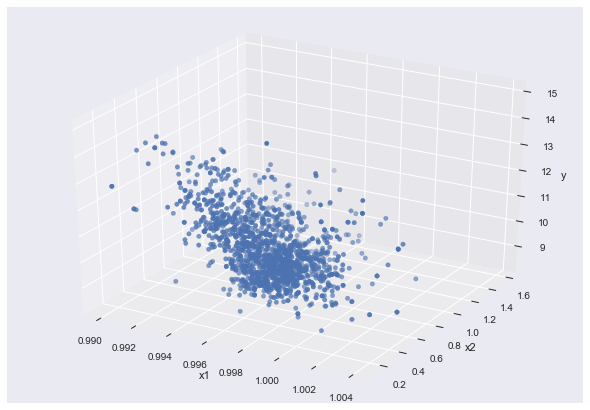

In [4]:
from mpl_toolkits.mplot3d import Axes3D  #3Dplot
import matplotlib.pyplot as plt
import seaborn as sns

fig=plt.figure()
ax=Axes3D(fig)
 
ax.scatter3D(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
 
plt.show()

## 正規化

　重回帰分析で、入力変数が複数になったことで重要なこととして、正規化の必要性が挙げられます。

　何故正規化が必要かというと、入力変数の単位（m, mm）や比べる対象（温度、密度）が異なり、そのままの数字を使うと、影響度合いをうまく評価できないからです。1mの変化と1mmの変化を同じ尺度で考えてはいけないのは、直感的にも分かりますよね。

　これらの変数ごとの粒度を揃えるためのデータに対して行われる前処理が正規化(normalization)です。正規化の代表的な手法は以下2つです。

- 標準化 (standardization)：平均、分散（標準偏差）を使ったもの（平均を0、分散を1にする）
- Min-Maxスケーリング(min-max scaling)：最小値(min)、最大値(max)を使ったもの（全体を 0〜1にする）

　分野によっては「正規化=標準化」だったと定義が異なり紛らわしいですが、データを一定のルールに基づいて変形して、利用しやすくすることは全て正規化と呼ぶのが一般的なようです。

　数式に関しては、以下サイト参照ください。

https://fisproject.jp/2016/06/data-standardization-using-python/

　それぞれ説明していきます。

### 標準化
平均と分散を使って、平均値が0、分散が1になるようにするのが標準化です。なお、標準偏差の二乗が分散なので、これ以降では分散=標準偏差として記載していきます、ご了承下さい。

平均、分散（標準偏差）を使った標準化で紛らわしいのが、分散と不偏分散（不偏標準偏差）の違いです。

統計が専門の人は分散といえば不偏分散を当たり前のように使うので、結構食い違うことがあります。

不偏分散を使う理由は、統計的に扱うときに色々便利だかららしいのですが、この辺りは、私自身説明できるほど理解できていませんので、詳しい説明は以下リンク先など参照下さい（理解できるようになったら、このページにも追記します）。

- https://mathtrain.jp/huhenbunsan
- https://manareki.com/unbiased_std_v
- https://to-kei.net/basic/glossary/variance/

　また、更にややこしいのが、Pythonのライブラリのscikit-learn, pandas, numpy 機械学習でよく使われるR言語で、分散（標準偏差）をもとめるとき、デフォルトでの計算結果が、分散(population standard deviation)だったり不偏分散(sample standard deviation)だったりする点です。なので、初心者は値が合わずにパニックに陥ります（私はパニックでした）。
 
 ちなみにデフォルトは以下のようです。ややこし過ぎですね。
 
 - scikit-learn: 分散
 - pandas: 不偏分散
 - numpy: 分散
 - R言語: 不偏分散

具体的に計算して確認していきます。

#### scikit-learnのStandardScalerを使う方法

scikit-learnのStandardScalerメソッドでは、コマンド一発でいわゆる普通の分散を用いて標準化を行います。

In [5]:
from sklearn import preprocessing

sscaler = preprocessing.StandardScaler()
sscaler.fit(x)
xss_sk = sscaler.transform(x) 
sscaler.fit(y)
yss_sk = sscaler.transform(y)

print(xss_sk)
print(yss_sk)

[[ 0.55827446  0.96187667]
 [ 0.02826077  1.96744245]
 [ 0.13426351  1.29706527]
 ...
 [-0.53355375 -0.09955388]
 [-0.67665745  0.65462046]
 [-0.66605717 -1.21684919]]
[[-0.96024611]
 [-0.58477711]
 [-0.58477711]
 ...
 [ 0.54162988]
 [-0.20930812]
 [ 0.54162988]]


#### pandasを使う方法

pandasで正規化する場合は、デフォルトのstdメソッドは不偏分散を使って求めます。確認してみましょう。scikit-learnの求める値と異なる値になることがわかります。

In [6]:
xss_pd = (x - x.mean()) / x.std()
yss_pd = (y - y.mean()) / y.std()

print(xss_pd.head())
print(yss_pd.head())

    density  volatile acidity
0  0.558100          0.961576
1  0.028252          1.966827
2  0.134222          1.296660
3  0.664069         -1.384011
4  0.558100          0.961576
    alcohol
0 -0.959946
1 -0.584594
2 -0.584594
3 -0.584594
4 -0.959946


不偏分散でなく、いわゆる普通の分散を用いたい場合は、stdメソッドのddofオプションを使います。

pandasのstdメソッドのddofオプションのデフォルト値は不偏分散を求める`ddof=1`です。`ddof=0`を設定（いわゆる普通の）分散を使うと、scikit-learnの求める値と同じになります。確認してみます。

In [7]:
xss_pd = (x - x.mean()) / x.std(ddof=0)
yss_pd = (y - y.mean()) / y.std(ddof=0)

print(xss_pd.head())
print(yss_pd.head())

    density  volatile acidity
0  0.558274          0.961877
1  0.028261          1.967442
2  0.134264          1.297065
3  0.664277         -1.384443
4  0.558274          0.961877
    alcohol
0 -0.960246
1 -0.584777
2 -0.584777
3 -0.584777
4 -0.960246


scikit-learnのStandardScalerメソッドで求めた値と同じになりました。

#### Numpyを使う方法

続いてNumpyで計算します。Numpyでは、デフォルトは普通の分散です。scikit-learnのStandardScalerメソッドの計算値と同じになることを確認して下さい。

In [8]:
import numpy as np

x_np = x.apply(lambda x: (x - np.mean(x)) / np.std(x))
y_np = y.apply(lambda x: (x - np.mean(x)) / np.std(x))

print(x_np.head())
print(y_np.head())

    density  volatile acidity
0  0.558274          0.961877
1  0.028261          1.967442
2  0.134264          1.297065
3  0.664277         -1.384443
4  0.558274          0.961877
    alcohol
0 -0.960246
1 -0.584777
2 -0.584777
3 -0.584777
4 -0.960246


pandasと同様にddofオプションを使うと、不偏分散も求められます。Numpyの場合は`ddof=1`とします。

In [9]:
x_np = x.apply(lambda x: (x - np.mean(x)) / np.std(x, ddof=1))
y_np = y.apply(lambda x: (x - np.mean(x)) / np.std(x, ddof=1))

print(x_np.head())
print(y_np.head())

    density  volatile acidity
0  0.558100          0.961576
1  0.028252          1.966827
2  0.134222          1.296660
3  0.664069         -1.384011
4  0.558100          0.961576
    alcohol
0 -0.959946
1 -0.584594
2 -0.584594
3 -0.584594
4 -0.959946


#### 標準化のまとめ
分散か不偏分散かを意識して標準化を行うことが重要です。少なくとも、どちらで正規化をしているのかを把握するようにしておきましょう。そうしないと、思わぬ計算違いをしていまうことになります。

最後に、平均、分散を使って正規化した変数の平均が0、分散が1になることを確認しましょう。分散のときは、分散か不偏分散かを意識します。

In [10]:
x_np.mean()

density             3.772732e-13
volatile acidity   -1.590973e-15
dtype: float64

In [11]:
y_np.mean()

alcohol    2.580411e-14
dtype: float64

In [12]:
x_np.std()

density             1.0
volatile acidity    1.0
dtype: float64

In [13]:
y_np.std()

alcohol    1.0
dtype: float64

例えば、ここで不偏分散を用いて計算するところで、普通の分散を用いて計算すると、間違った答えが出てきてしまいます

In [14]:
x_np.std(ddof=0)

density             0.999687
volatile acidity    0.999687
dtype: float64

In [15]:
y_np.std(ddof=0)

alcohol    0.999687
dtype: float64

### min-maxスケーリング

最小値と最大値を使って、最大値が1, 最小値が0になるように正規化をします。

最小値、最大値は、それほど複雑ではないので、scikit-learnを使って計算した例と、Numpyを使って計算した例を紹介します。

In [16]:
mscaler = preprocessing.MinMaxScaler()
mscaler.fit(x)
xms = mscaler.transform(x)
mscaler.fit(y)
yms = mscaler.transform(y)

print(xms)
print(yms)

[[0.56754772 0.39726027]
 [0.49412628 0.52054795]
 [0.50881057 0.43835616]
 ...
 [0.41629956 0.26712329]
 [0.39647577 0.35958904]
 [0.3979442  0.13013699]]
[[0.15384615]
 [0.21538462]
 [0.21538462]
 ...
 [0.4       ]
 [0.27692308]
 [0.4       ]]


In [17]:
x_ms = x.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
y_ms = y.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

print(x_ms.head())
print(y_ms.head())

    density  volatile acidity
0  0.567548          0.397260
1  0.494126          0.520548
2  0.508811          0.438356
3  0.582232          0.109589
4  0.567548          0.397260
    alcohol
0  0.153846
1  0.215385
2  0.215385
3  0.215385
4  0.153846


## scikit-learnを使った重回帰分析

### 正規化無し
まずは正規化なしで行います

In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np

model_lr = LinearRegression()
model_lr.fit(x, y)

print(model_lr.coef_)
print(model_lr.intercept_)
print(model_lr.score(x, y))

[[-277.78274856   -1.13941954]]
[287.90342428]
0.28283042699952976


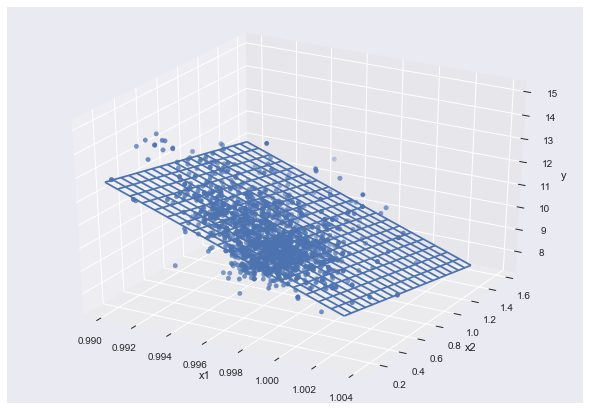

[[-277.78274856   -1.13941954]]
[287.90342428]
0.28283042699952976


In [21]:
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter3D(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")

mesh_x1 = np.arange(x1.min()[0], x1.max()[0], (x1.max()[0]-x1.min()[0])/20)
mesh_x2 = np.arange(x2.min()[0], x2.max()[0], (x2.max()[0]-x2.min()[0])/20)
mesh_x1, mesh_x2 = np.meshgrid(mesh_x1, mesh_x2)
mesh_y = model_lr.coef_[0][0] * mesh_x1 + model_lr.coef_[0][1] * mesh_x2 + model_lr.intercept_[0]
ax.plot_wireframe(mesh_x1, mesh_x2, mesh_y)
plt.show()

print(model_lr.coef_)
print(model_lr.intercept_)
print(model_lr.score(x, y))

### 正規化（標準化）
次は、先ほど行った標準化した値で重回帰分析を行います。
StandardScalerを使用して求めた、xss_sk, yss_sk を用います。

In [19]:
model_lr_std = LinearRegression()
model_lr_std.fit(xss_sk, yss_sk)

print(model_lr_std.coef_)
print(model_lr_std.intercept_)
print(model_lr_std.score(xss_sk, yss_sk))

[[-0.49196281 -0.19145194]]
[1.1769986e-14]
0.28283042699952887


標準化して平均が0になるような値になっているので、切片 `model_lr.intercept_` が0となっています。
一方、scoreに関しては、正規化しても変わりません。

ここで、標準化した値 x を使ったモデルを使って xからy を計算（予測）するときは、そのままだと標準化した値が出てきてしまいます。

具体的には、まず正規化無しで作成したモデルを使って予想します。これが本来求めたい値です。

In [20]:
model_lr.predict(x)

array([[ 9.93420409],
       [10.00689132],
       [10.08806511],
       ...,
       [10.72292626],
       [10.64410597],
       [11.02025586]])

In [ ]:
次に、正規化した後に作成したモデルを使って予測します。

In [21]:
model_lr_std.predict(xss_sk)

array([[-0.45880343],
       [-0.39057392],
       [-0.31437831],
       ...,
       [ 0.28154838],
       [ 0.20756194],
       [ 0.56064349]])

本来求めたい値と大きく異なります。これだと実際に予測したいときに困ってしまいますね。

この場合、正規化する前のモデルで逆変換して戻してあげる必要があります。

In [22]:
model_lr_std.predict(xss_sk) * np.std(y.values) + np.mean(y.values)

array([[ 9.93420409],
       [10.00689132],
       [10.08806511],
       ...,
       [10.72292626],
       [10.64410597],
       [11.02025586]])

### 正規化あり（min-maxスケーリング）
次は、min-maxスケーリングした値で重回帰分析を行います。

In [23]:
model_lr_norm = LinearRegression()
model_lr_norm.fit(xms, yms)

print(model_lr_norm.coef_)
print(model_lr_norm.intercept_)
print(model_lr_norm.score(xms, yms))

[[-0.5820617  -0.25593116]]
[0.66805047]
0.28283042699952876


同様に、yの値を予測するときには、以下のように逆変換をしてやる必要があります。

In [24]:
model_lr_norm.predict(xms) * (np.max(y.values) - np.min(y.values)) + np.min(y.values)

array([[ 9.93420409],
       [10.00689132],
       [10.08806511],
       ...,
       [10.72292626],
       [10.64410597],
       [11.02025586]])

## Numpyを使った重回帰分析

次にscikit-learnを使わず、Numpyで重回帰分析を行います。

単回帰の場合は、回帰変数は共分散と分散から計算できましたが、重回帰の場合は、変数が複数になるため、正規方程式 (normal equation) と呼ばれる方程式を解くために、行列演算を行う必要があります。

式の導出や説明などは、以下サイトを参照下さい。

https://tutorials.chainer.org/ja/07_Regression_Analysis.html

また、ここでの計算は正規化を行った前提となります。

最初に、再度scikit-learnを使った重回帰での回帰変数の値を確認しましょう（x, yは標準化した値です）

In [25]:
model_lr_std.fit(xss_sk, yss_sk)

print(model_lr_std.coef_)

[[-0.49196281 -0.19145194]]


Numpyで行列演算を行い計算します。

`@`は行列の積です。この書き方は、以下の本を参照にしました。

また、逆行列を求める`linalg`モジュールは`LA`としてimportするのが通例のようなので、ここではそれに倣います

In [26]:
from numpy import linalg as LA

LA.inv(xss_sk.T @ xss_sk) @ xss_sk.T @ yss_sk

array([[-0.49196281],
       [-0.19145194]])

scikit-learnの値と一致しました。

なお、Numpyで逆行列が計算できないときは、`LinAlgError: Singular matrix` というエラーが発生します。

逆行列が計算できないときは、微小な値を加えるといったテクニックが必要になりますが、Numpyで手軽に求める場合はpinvを用いて以下のように計算しましょう。

In [27]:
np.linalg.pinv(xss_sk.T @ xss_sk) @ xss_sk.T @ yss_sk

array([[-0.49196281],
       [-0.19145194]])

## 決定係数
続いて決定係数 R を求めます。Rが1に近いほど、xがyを説明できているものです。

決定変数は、単回帰のときと同様、全変動(Sall)、回帰変動(Sreg), 残差変動(Sres)から計算できますが、入力変数が多くなるほど1に近づくので、入力変数が複数あるときは入力変数の数(p)で補正する「自由度調整済み決定係数」Rfを用います。

Sall, Sreg, Sresには以下のような関係があります。

Sall = Sreg + Sres

Rf = 1 - (Sres / (n-p-1) / (Sall / (n-1))

R^2 = r^2

詳細は、以下サイトを参照下さい。ここでは、それぞれをNumpyで計算していきます。

- https://bellcurve.jp/statistics/course/9706.html
- https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0

In [28]:
s_all = 0

for y_i in yss_sk:
    s_all += (y_i - yss_sk.mean())**2

s_all = s_all / yss_sk.size
print(s_all)

[1.]


In [29]:
s_reg = 0

for x_i in xss_sk:
    s_reg += (model_lr_std.predict(x_i.reshape(1,-1))[0][0] - yss_sk.mean())**2

s_reg = s_reg / yss_sk.size
print(s_reg)

0.2828304269995288


In [30]:
s_res = 0

for x_i, y_i in zip(xss_sk, yss_sk):
    s_res += (y_i - model_lr_std.predict(x_i.reshape(1,-1))[0][0])**2 

s_res = s_res / yss_sk.size
print(s_res)

[0.71716957]


Sall = Sreg + Sres の確認

In [31]:
print('Sall: %.3f' %s_all)
print('Sreg + Sres: %.3f' %(s_reg + s_res))

Sall: 1.000
Sreg + Sres: 1.000


Rf = 1 - (Sres / (n-p-1) / (Sall / (n-1))

よりRfを計算

今回入力変数の数は2なので p=2

In [32]:
1 - (s_res / (yss_sk.size - 2 - 1)) / (s_all / (yss_sk.size -1))

array([0.28193172])

単回帰の要領で、決定係数を求めると、少し値が大きくなっているのがわかります。

In [33]:
s_reg / s_all

array([0.28283043])

今回は、入力変数の数が2なので、それほど差がないですが、入力変数が増えるほどこの差が広がっていきます。

## 相関行列

次に入力変数の相関関係を確認するために、相関行列を求めます。

https://algorithm.joho.info/programming/python/scikit-learn-datasets-load_diabetes/
http://zellij.hatenablog.com/entry/20130510/p1

scikit-learnでは、以下のように相関行列を求めます。

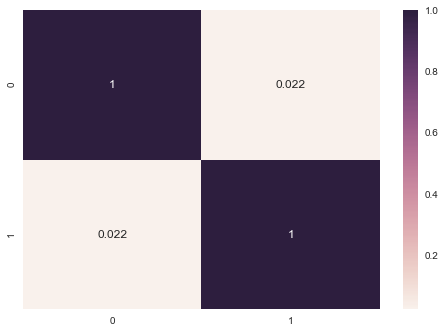

In [34]:
import seaborn as sns

# 相関係数を計算
corr = np.corrcoef(xss_sk.T)

# 相関係数をヒートマップで可視化
sns.heatmap(corr, annot=True)
plt.show()

Numpyでは、入力変数の転置行列と入力の行列の積を計算して、対角行列が1になるようにスケーリングすると求められます

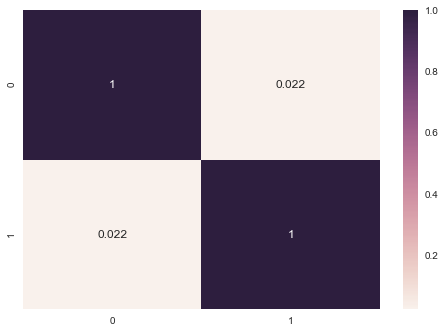

In [35]:
corr_np = (xss_sk.T) @ (xss_sk) / yss_sk.size

sns.heatmap(corr_np, annot=True)
plt.show()

相関行列の対角以外の要素を相関係数と呼びます。

相関係数が大きいと、変数間の相関が強く、変数間が独立ではない（線形従属）ことになります。この現象を「多重共線性」といいます。

定量的には、行列の固有値を計算して確認できます。

In [36]:
w, v = LA.eig(corr)
print(w)

[1.02202623 0.97797377]


このとき、相関行列の固有値の1部がほぼ0になると「多重共線性」となります。今回は、問題無いようです。

多重共線性になると、解が計算できなかったり、信頼性が低下してしまいます。そのため、高い相関値をもつ説明変数を取り除くなどの対策を取る必要があります。

## 多重共線性の対策
具体的には「正則化」と「次元削減」の2種類があり、それぞれ様々な手法があります。一部を紹介すると以下のようになります。

https://www.ydc.co.jp/column/0002/20190213l.html

具体的な対策方法の紹介に関しては、またいずれ…

### 正則化
回帰係数が大きくなりすぎないように小さく抑える方法です。

具体的には、以下手法があります。

- リッジ回帰(Ridge Regression)
- L2正則化最小二乗法（q=2）

### 次元削減
　大きく、特徴を選択する方法（1部の入力変数のみを使用する、不要な入力変数を削除する）と特徴を抽出する方法（複数の変数を1つにまとめる、変換する）の2つがあります。それぞれの手法を紹介します。
  
#### 特徴選択
- LASSO

#### 特徴を抽出する
- 主成分分析

## 統計的な解釈

最後に、単回帰のときと同様に統計的な解釈を行います。ここは、statsmodelというライブラリを使って一気にやってしまいます。

こちらの詳細に関しては、今回は省略します（力尽きました…）。

In [37]:
import statsmodels.api as sm

x_add_const = sm.add_constant(xss_sk)
model_sm = sm.OLS(yss_sk, x_add_const).fit()
print(model_sm.summary())

/Users/karaage/.pyenv/versions/anaconda3-4.4.0/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     314.7
Date:                Thu, 12 Sep 2019   Prob (F-statistic):          6.11e-116
Time:                        00:55:31   Log-Likelihood:                -2003.1
No. Observations:                1599   AIC:                             4012.
Df Residuals:                    1596   BIC:                             4028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.191e-14      0.021   5.62e-13      1.0

## 参考
- https://alexandco-python.tokyo/archives/240
- https://openbook4.me/projects/183/sections/1366
- https://www.enisias.cloud/machine-learning/526/
- https://qiita.com/yossyyossy/items/ac6961ca5a0e765f56be
- https://qiita.com/avengers_/items/faa735ae0db9655b2ea9
- http://www.snap-tck.com/room04/c01/stat/stat07/stat0701.html
- http://short4010.hatenablog.com/entry/2018/03/01/222721
- https://qiita.com/seno/items/14fad1ef792e48f4d4d6